# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler
import copy


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN


sns.set(font_scale=1.5)

# Functions

In [ ]:
def create_dataset(x, y, time_steps=1, pred_time_steps=1, overlap=True):
    xs, ys = [], []
    if overlap:
        jump = 1
    else:
        jump = pred_time_steps
    for i in range(0, len(x) - time_steps - pred_time_steps + 1, jump):
        v = x[i:(i + time_steps), :]
        xs.append(v)
        ys.append(y[i + time_steps:i + time_steps + pred_time_steps])
    return np.array(xs), np.array(ys)

In [ ]:
def make_RNN_model(input_shape, layers, dense_layers, activation, output, activation_out, rnn_layer='simple'):
    model = []
    ret_sequences = True
    if rnn_layer == 'lstm':
        layer = LSTM(units=layers[0], return_sequences=ret_sequences, input_shape=input_shape)
    elif rnn_layer == 'gru':
        layer = GRU(units=layers[0], return_sequences=ret_sequences, input_shape=input_shape)
    else:
        layer = SimpleRNN(units=layers[0], return_sequences=ret_sequences, input_shape=input_shape)

    model.append(layer)

    for i in range(1, len(layers)):
        if i == len(layers)-1:
            ret_sequences = False

        if rnn_layer == 'lstm':
            layer = LSTM(units=layers[i], return_sequences=ret_sequences)
        elif rnn_layer == 'gru':
            layer = GRU(units=layers[i], return_sequences=ret_sequences)
        else:
            layer = SimpleRNN(units=layers[i], return_sequences=ret_sequences)
        model.append(layer)

    for dl in dense_layers:
        model.append(tf.keras.layers.Dense(dl, activation=activation))

    model.append(tf.keras.layers.Dense(output, activation=activation_out))
    model = tf.keras.Sequential(model)

    return model

In [ ]:
def train_RNN_network(train, test, val, layers, dense_layers, activation, output, activation_out, lags, epochs, batch_size, opt, loss, factor=0.8, patience_reduce=3, patience_early=5, rnn_layer='simple'):
    dict_results = {'Lags': [], 'MAE': [], 'RMSE': [], 'R2': []}
    for i in lags:
        x_train, y_train = create_dataset(train, train, i, output, True)
        x_val, y_val = create_dataset(val, val, i, output, False)
        x_test, y_test = create_dataset(test, test, i, output, False)

        model = make_RNN_model((i,1), layers, dense_layers, activation, output, activation_out, rnn_layer)

        opt_tmp = copy.copy(opt)
        model_tmp = tf.keras.models.clone_model(model)
        model_tmp.compile(optimizer=opt_tmp, loss=loss, metrics=['mae', 'mse'])
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=factor, patience=patience_reduce)
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early, restore_best_weights=True)
        history = model_tmp.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[reduce_lr, early_stopping])

        y_pred = model_tmp.predict(x_test, verbose=0, batch_size=batch_size)
        y_pred = scaler.inverse_transform(y_pred).flatten()
        y_test = scaler.inverse_transform(y_test[:,:,0]).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        dict_results['MAE'].append(mae)
        dict_results['RMSE'].append(rmse)
        dict_results['R2'].append(r2)
        dict_results['Lags'].append(i)

        print('MAE:', mae, 'RMSE:', rmse, 'and R2:', r2, 'for', i, 'lags')
    return pd.DataFrame(dict_results)

# About Dataset
This dataset is the most up-to-date kaggle dataset about daily sunspot counts with no missing values. The source data originate from the World Data Center SILSO, Royal Observatory of Belgium, Brussels.

The Daily total sunspot number is derived by the formula: R = Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk. The original data contained some values between 1818 and 1850 but I removed those years because there was too much missing values.


**Error values**

Those values correspond to the standard deviation of raw numbers provided by all stations.

* Before 1981, the errors are estimated with the help of an auto-regressive model based on the Poissonian distribution of actual Sunspot Numbers.
* From 1981 onwards, the error value is the actual standard deviation of the sample of raw observations used to compute the daily value.

**The standard error of the daily Sunspot Number can be computed by:**

sigma/sqrt(N) where sigma is the listed standard deviation and N the number of observations for the day.
Before 1981, the number of observations is set to 1, as the Sunspot Number was then essentially the raw Wolf number from the Zürich Observatory.


**Columns Description**

* Column 1-3: Gregorian calendar date
    * Year
    * Month
    * Day
* Column 4: Date in fraction of year
*  Column 5: Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value): there should not be any missing values as I removed all years before 1850 where there was missing values.
* Column 6: Daily standard deviation of the input sunspot numbers from individual stations.
* Column 7: Number of observations used to compute the daily value.
* Column 8: Definitive/provisional indicator. A blank (NaN) indicates that the value is definitive. A '*' symbol indicates that the value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)

# Preprocessing data

## Read data

In [ ]:
df = pd.read_csv('sunspots_1850_2024.csv')
df.head()

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN


## Make dataset

In [ ]:
df = pd.DataFrame(df.groupby(pd.PeriodIndex(df['date'], freq="D"))['counts'].mean())
df = df.reset_index()
df['date'] = df['date'].dt.to_timestamp('s').dt.strftime(r'%Y-%m-%d')
df = df.set_index('date')
df.head()

,counts
date,
1850-01-01,253.0
1850-01-02,162.0
1850-01-03,217.0
1850-01-04,99.0
1850-01-05,108.0


# Exploratory Analysis

## Plot sunspots monthly mean by time

(array([    0,  1460,  2920,  4380,  5840,  7300,  8760, 10220, 11680,
        13140, 14600, 16060, 17520, 18980, 20440, 21900, 23360, 24820,
        26280, 27740, 29200, 30660, 32120, 33580, 35040, 36500, 37960,
        39420, 40880, 42340, 43800, 45260, 46720, 48180, 49640, 51100,
        52560, 54020, 55480, 56940, 58400, 59860, 61320, 62780]),
 [Text(0, 0, '1850-01-01'),
  Text(1460, 0, '1853-12-31'),
  Text(2920, 0, '1857-12-30'),
  Text(4380, 0, '1861-12-29'),
  Text(5840, 0, '1865-12-28'),
  Text(7300, 0, '1869-12-27'),
  Text(8760, 0, '1873-12-26'),
  Text(10220, 0, '1877-12-25'),
  Text(11680, 0, '1881-12-24'),
  Text(13140, 0, '1885-12-23'),
  Text(14600, 0, '1889-12-22'),
  Text(16060, 0, '1893-12-21'),
  Text(17520, 0, '1897-12-20'),
  Text(18980, 0, '1901-12-20'),
  Text(20440, 0, '1905-12-19'),
  Text(21900, 0, '1909-12-18'),
  Text(23360, 0, '1913-12-17'),
  Text(24820, 0, '1917-12-16'),
  Text(26280, 0, '1921-12-15'),
  Text(27740, 0, '1925-12-14'),
  Text(29200, 0, '19

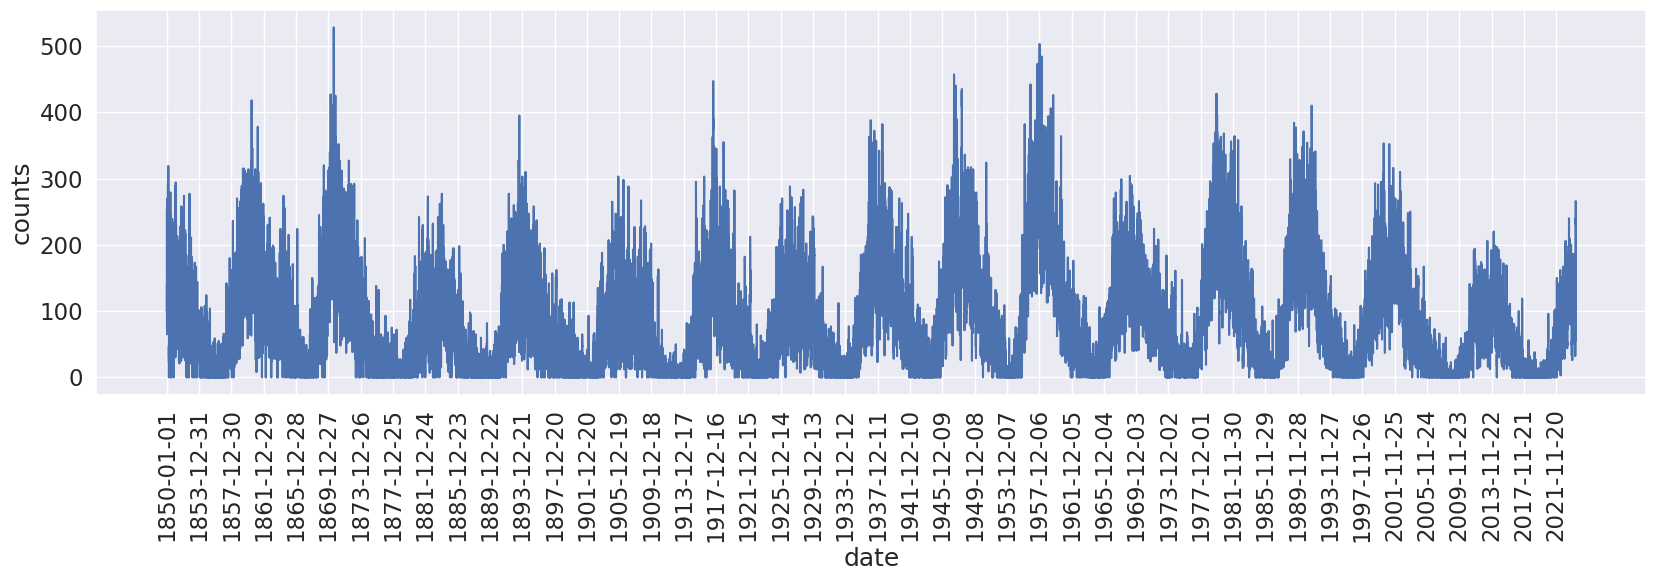

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(y=df['counts'], x=df.index)
ax.set_xticks(ax.get_xticks()[::1460])
plt.xticks(rotation=90)

In [ ]:
df.describe()

,counts
count,63673.000000
mean,83.410174
std,76.875804
min,0.000000
25%,21.000000
50%,64.000000
75%,128.000000
max,528.000000


# Prepare data

## Scale data

In [ ]:
scaler  = MinMaxScaler() # scaler
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled = df_scaled.rename(columns = {0: 'value'})
df_scaled.head()

,value
0,0.479167
1,0.306818
2,0.410985
3,0.187500
4,0.204545


## Split data

In [ ]:
train_split = int(len(df) * 0.7)
val_split = int(len(df) * 0.1)

In [ ]:
df_train = df_scaled[:train_split].to_numpy()
df_val = df_scaled[train_split:train_split+val_split].to_numpy()
df_test = df_scaled[train_split+val_split:].to_numpy()

# Train RNN

## Simple RNN

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
scores = train_RNN_network(train=df_train, test=df_test, val=df_val, layers=[64,64], dense_layers=[32],
                           activation='relu', output=7, activation_out=None, lags=[7,15,30], epochs=30, batch_size=1024, opt=opt,
                           loss='mse', rnn_layer='simple')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 23.223288243547206 RMSE: 32.914467590888954 and R2: 0.7876832371199106 for 7 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 21.163266190432633 RMSE: 30.449239585959397 and R2: 0.8176703250548811 for 15 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.964302389117876 RMSE: 28.83259759455799 and R2: 0.8363838239469469 for 30 lags


<Axes: xlabel='Lags', ylabel='RMSE'>

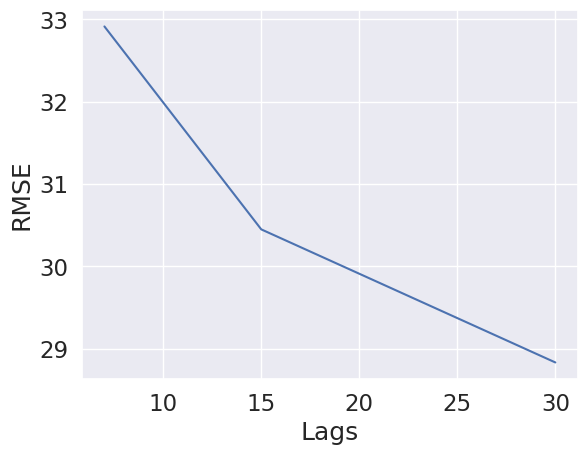

In [ ]:
sns.lineplot(data=scores, x='Lags', y='RMSE')

## GRU

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
scores = train_RNN_network(train=df_train, test=df_test, val=df_val, layers=[64,64], dense_layers=[32],
                           activation='relu', output=7, activation_out=None, lags=[7,15,30,60,120,365], epochs=30, batch_size=1024, opt=opt,
                           loss='mse', rnn_layer='gru')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 23.358448022775413 RMSE: 32.8147722614034 and R2: 0.788967470747582 for 7 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 20.86968592821741 RMSE: 30.271828957735455 and R2: 0.8197888007909402 for 15 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.75041058830087 RMSE: 28.64039981953406 and R2: 0.8385578808166343 for 30 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.480382922524623 RMSE: 28.451428050930858 and R2: 0.8387766396237264 for 60 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.806923140923043 RMSE: 28.029357240898335 and R2: 0.8404624653511794 for 120 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.227882455358877 RMSE: 27.704658258712794 and R2: 0.8349565941742692 for 365 lags


<Axes: xlabel='Lags', ylabel='RMSE'>

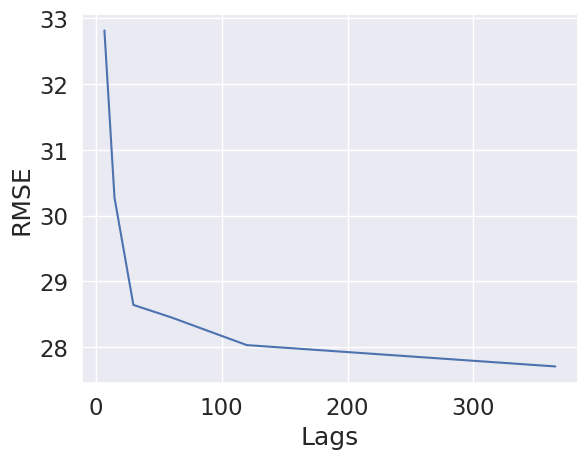

In [ ]:
sns.lineplot(data=scores, x='Lags', y='RMSE')

## LSTM

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
scores = train_RNN_network(train=df_train, test=df_test, val=df_val, layers=[64,64], dense_layers=[32],
                           activation='relu', output=7, activation_out=None, lags=[7,15,30,60,120,365], epochs=30, batch_size=1024, opt=opt,
                           loss='mse', rnn_layer='lstm')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 23.062941194273815 RMSE: 32.838824890494045 and R2: 0.7886579913839566 for 7 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 20.966377934960413 RMSE: 30.32979046250222 and R2: 0.8190980389527881 for 15 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.85067859547479 RMSE: 28.702043031210625 and R2: 0.837862183793306 for 30 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.706498092657576 RMSE: 28.51654910314639 and R2: 0.8380377628117226 for 60 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.845446708298947 RMSE: 28.23716479584517 and R2: 0.8380880975032029 for 120 lags


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.316570650313007 RMSE: 27.90923358508944 and R2: 0.8325101848524465 for 365 lags


<Axes: xlabel='Lags', ylabel='RMSE'>

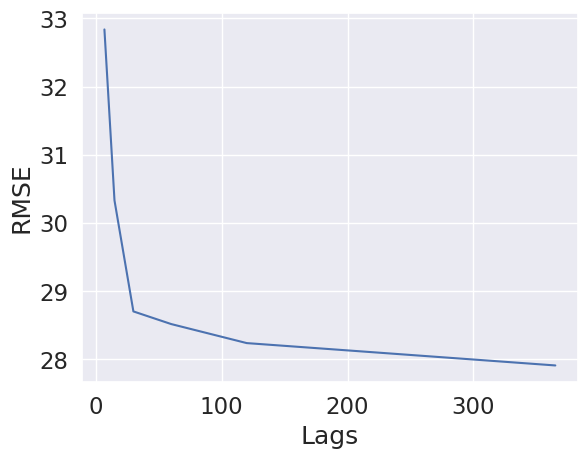

In [ ]:
sns.lineplot(data=scores, x='Lags', y='RMSE')

# Select one model

In [ ]:
time_steps = 120
pred_time_steps = 7
x_train, y_train = create_dataset(df_train, df_train, time_steps, pred_time_steps, True)
x_val, y_val = create_dataset(df_val, df_val, time_steps, pred_time_steps, True)
x_test, y_test = create_dataset(df_test, df_test, time_steps, pred_time_steps, False)

In [ ]:
model = make_RNN_model(input_shape=(time_steps, 1), layers=[64,64], dense_layers=[32], activation='relu',
                       output=pred_time_steps, activation_out=None, rnn_layer='gru')
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)
model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=300, batch_size=1024, verbose=1, callbacks=[reduce_lr, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [ ]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')

NameError: name 'history' is not defined

## Test results

In [ ]:
y_pred = scaler.inverse_transform(model.predict(x_test)).flatten()
y_true = scaler.inverse_transform(y_test[:,:, 0]).flatten()

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


MAE: 72.96284922892873 
RMSE: 100.95250790787351 
R2: -1.0695256986752826


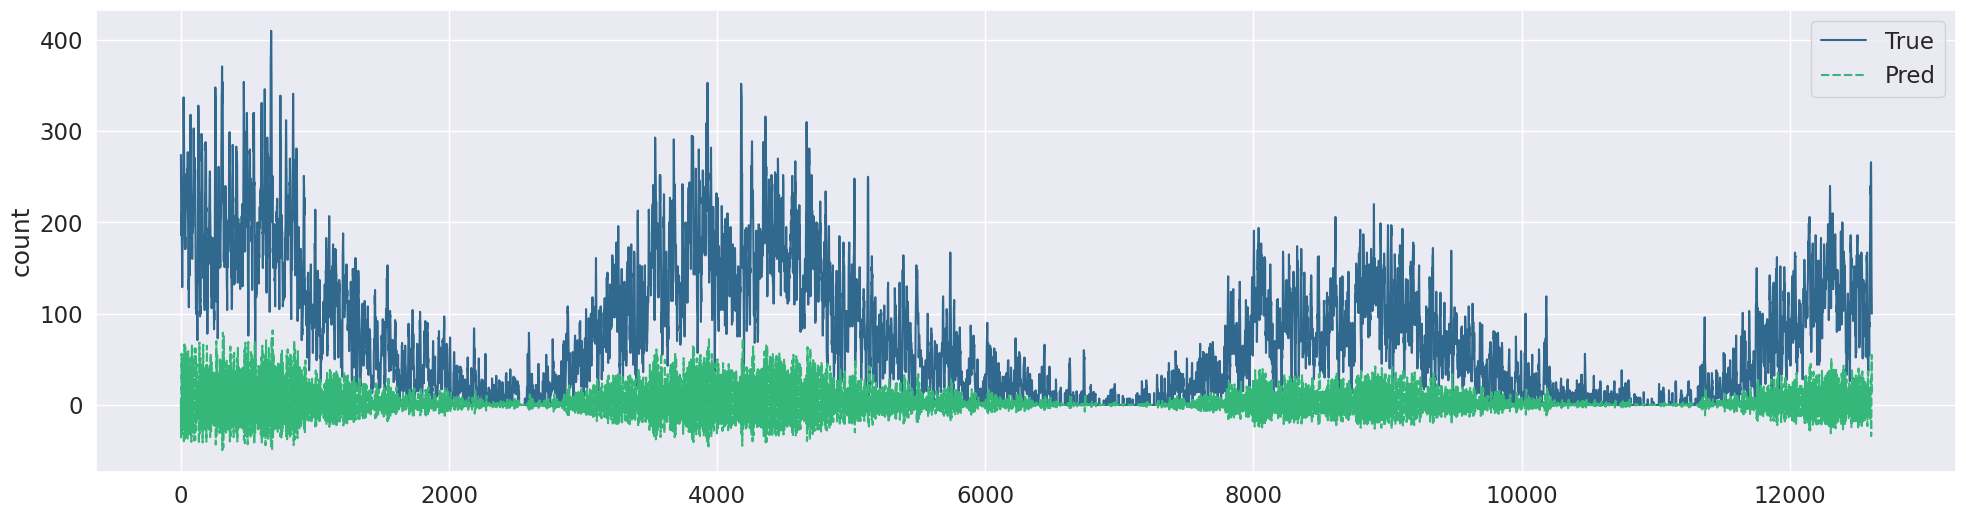

In [ ]:
plt.figure(figsize=(24,6))
res = {'True': y_true, 'Pred': y_pred}
sns.lineplot(data=res, palette='viridis')
plt.ylabel('count')
print('MAE:', mean_absolute_error(y_true, y_pred), '\nRMSE:', np.sqrt(mean_squared_error(y_true, y_pred)), '\nR2:', r2_score(y_true, y_pred))